In [1]:
# Install the torch package
%pip install torch numpy matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import random

import pandas as pd
import matplotlib.pyplot as plt

from goyalWelchData import GoyalWelchData
from flexibleMLP import FlexibleMLP
from functions import *


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
goyal_welch_data = GoyalWelchData(input_file='tlt_monthly_returns.csv', symbol = 'TLT')
X_train, X_test, y_train, y_test, test_dates = goyal_welch_data.get_train_and_test_data()

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets and DataLoaders for training and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


/workspaces/Quantative-Macroeconomics-with-Python/notebooks/goyalWelchData.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.goyal_welch_data['excess_returns'] = self.monthly_returns[symbol] - self.goyal_welch_data.Rfree


In [3]:
# Initialize the deep neural network model
num_seeds = 10
ridge_penalty = 0.001

FlexibleMLP.set_seed(42)
width = 100
model_architecture = [X_train.shape[1], width, width, 1]
models = [FlexibleMLP(model_architecture) for seed in range(num_seeds)]

# Proceed with the rest of the setup (loss, optimizer) and training loop as before
# Loss and optimizer
for seed in range(num_seeds):

  FlexibleMLP.set_seed(seed)
  criterion = nn.MSELoss()
  #optimizer = optim.Adam(models[seed].parameters(), lr=0.001) #, weight_decay=0)  # Using Adam optimizer for better performance with deep networks
  optimizer = optim.SGD(models[seed].parameters(), lr=0.1)

  train_model(num_epochs=200,
              train_loader=train_loader,
              criterion=criterion,
              optimizer=optimizer,
              model=models[seed],
              ridge_penalty=ridge_penalty)

Epoch [20/200], Loss: 0.1996
Epoch [40/200], Loss: 0.1933
Epoch [60/200], Loss: 0.1874


Epoch [80/200], Loss: 0.1813
Epoch [100/200], Loss: 0.1757


Epoch [120/200], Loss: 0.1701
Epoch [140/200], Loss: 0.1646


Epoch [160/200], Loss: 0.1594
Epoch [180/200], Loss: 0.1545


Epoch [200/200], Loss: 0.1495
Epoch [20/200], Loss: 0.1984
Epoch [40/200], Loss: 0.1918


Epoch [60/200], Loss: 0.1855
Epoch [80/200], Loss: 0.1798
Epoch [100/200], Loss: 0.1741


Epoch [120/200], Loss: 0.1685
Epoch [140/200], Loss: 0.1633
Epoch [160/200], Loss: 0.1581


Epoch [180/200], Loss: 0.1531
Epoch [200/200], Loss: 0.1483
Epoch [20/200], Loss: 0.2027


Epoch [40/200], Loss: 0.1960
Epoch [60/200], Loss: 0.1897
Epoch [80/200], Loss: 0.1837


Epoch [100/200], Loss: 0.1779
Epoch [120/200], Loss: 0.1723


Epoch [140/200], Loss: 0.1668
Epoch [160/200], Loss: 0.1616
Epoch [180/200], Loss: 0.1565


Epoch [200/200], Loss: 0.1516
Epoch [20/200], Loss: 0.1989
Epoch [40/200], Loss: 0.1916


Epoch [60/200], Loss: 0.1858
Epoch [80/200], Loss: 0.1798


Epoch [100/200], Loss: 0.1741
Epoch [120/200], Loss: 0.1685
Epoch [140/200], Loss: 0.1632


Epoch [160/200], Loss: 0.1581
Epoch [180/200], Loss: 0.1533
Epoch [200/200], Loss: 0.1482


Epoch [20/200], Loss: 0.1990
Epoch [40/200], Loss: 0.1917
Epoch [60/200], Loss: 0.1855


Epoch [80/200], Loss: 0.1797
Epoch [100/200], Loss: 0.1741
Epoch [120/200], Loss: 0.1685


Epoch [140/200], Loss: 0.1633
Epoch [160/200], Loss: 0.1581


Epoch [180/200], Loss: 0.1531
Epoch [200/200], Loss: 0.1483
Epoch [20/200], Loss: 0.1951


Epoch [40/200], Loss: 0.1882
Epoch [60/200], Loss: 0.1821
Epoch [80/200], Loss: 0.1764


Epoch [100/200], Loss: 0.1706
Epoch [120/200], Loss: 0.1653
Epoch [140/200], Loss: 0.1600


Epoch [160/200], Loss: 0.1550
Epoch [180/200], Loss: 0.1501
Epoch [200/200], Loss: 0.1454


Epoch [20/200], Loss: 0.1958
Epoch [40/200], Loss: 0.1895


Epoch [60/200], Loss: 0.1834
Epoch [80/200], Loss: 0.1777


Epoch [100/200], Loss: 0.1720
Epoch [120/200], Loss: 0.1665


Epoch [140/200], Loss: 0.1613
Epoch [160/200], Loss: 0.1563


Epoch [180/200], Loss: 0.1513
Epoch [200/200], Loss: 0.1465
Epoch [20/200], Loss: 0.1879


Epoch [40/200], Loss: 0.1818
Epoch [60/200], Loss: 0.1762
Epoch [80/200], Loss: 0.1706


Epoch [100/200], Loss: 0.1651
Epoch [120/200], Loss: 0.1599
Epoch [140/200], Loss: 0.1549


Epoch [160/200], Loss: 0.1501
Epoch [180/200], Loss: 0.1453
Epoch [200/200], Loss: 0.1408


Epoch [20/200], Loss: 0.1962
Epoch [40/200], Loss: 0.1900
Epoch [60/200], Loss: 0.1840


Epoch [80/200], Loss: 0.1781
Epoch [100/200], Loss: 0.1723
Epoch [120/200], Loss: 0.1669


Epoch [140/200], Loss: 0.1616
Epoch [160/200], Loss: 0.1566
Epoch [180/200], Loss: 0.1516


Epoch [200/200], Loss: 0.1468
Epoch [20/200], Loss: 0.1986
Epoch [40/200], Loss: 0.1917


Epoch [60/200], Loss: 0.1856
Epoch [80/200], Loss: 0.1799


Epoch [100/200], Loss: 0.1741
Epoch [120/200], Loss: 0.1686
Epoch [140/200], Loss: 0.1633


Epoch [160/200], Loss: 0.1582
Epoch [180/200], Loss: 0.1532
Epoch [200/200], Loss: 0.1484


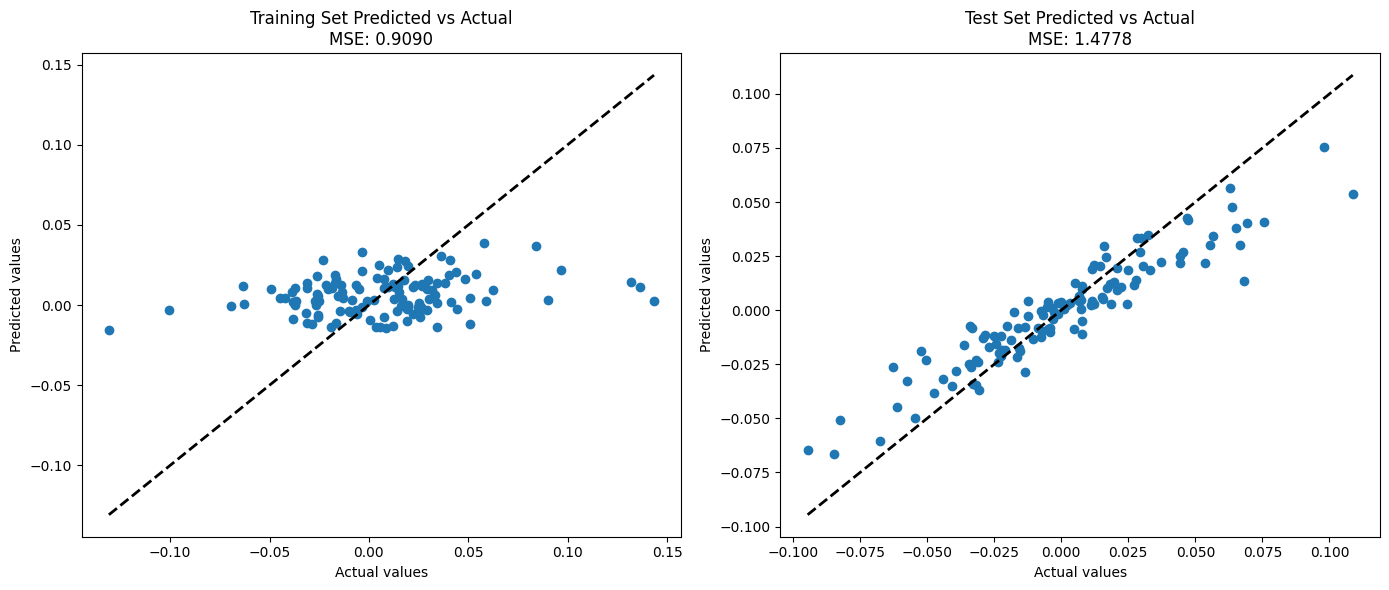

In [4]:
# Get predictions for both training and test sets
train_sample = [get_predictions(train_loader, models[seed]) for seed in range(num_seeds)]
test_sample = [get_predictions(test_loader, models[seed]) for seed in range(num_seeds)]
train_targets = train_sample[0][0]

#
train_predictions = np.concatenate([train_sample[seed][1].reshape(-1, 1) for seed in range(num_seeds)], axis=1).mean(1)

test_targets = test_sample[0][0]
all_test_predictions = np.concatenate([test_sample[seed][1].reshape(-1, 1) for seed in range(num_seeds)], axis=1)
test_predictions = all_test_predictions.mean(1)

# Calculate MSE for both training and test sets
train_mse = np.mean((train_targets - train_predictions) ** 2) / np.mean(train_targets ** 2)
test_mse = np.mean((test_targets.reshape(-1, 1) - test_predictions) ** 2) / np.mean(test_targets ** 2)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Training set subplot
axs[0].scatter(train_targets, train_predictions)
axs[0].plot([train_targets.min(), train_targets.max()], [train_targets.min(), train_targets.max()], 'k--', lw=2)  # Diagonal line
axs[0].set_xlabel('Actual values')
axs[0].set_ylabel('Predicted values')
axs[0].set_title(f'Training Set Predicted vs Actual\nMSE: {train_mse:.4f}')

# Test set subplot
axs[1].scatter(test_targets, test_predictions)#.mean(1))
axs[1].plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'k--', lw=2)  # Diagonal line
axs[1].set_xlabel('Actual values')
axs[1].set_ylabel('Predicted values')
axs[1].set_title(f'Test Set Predicted vs Actual\nMSE: {test_mse:.4f}')

plt.tight_layout()
plt.show()


Text(0.5, 1.0, '0    0.05\n1    2.23\ndtype: float32')

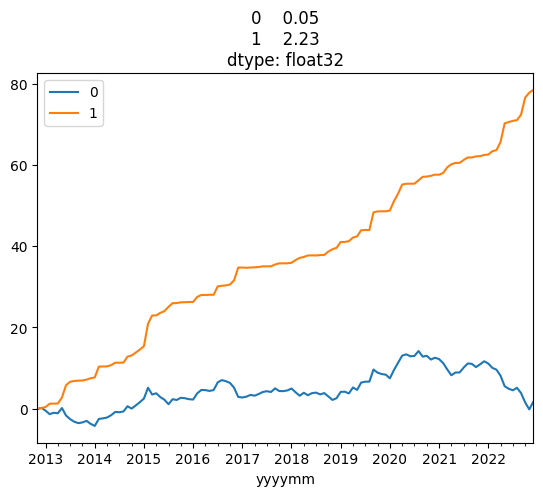

In [5]:
# now I define R_{t+1} * pi_t
# test_predictions have 10 columns, each column corresponding to a different random seed
timed_returns = test_targets.reshape(-1, 1) * test_predictions.reshape(-1, 1)
together = pd.DataFrame(np.concatenate([test_targets.reshape(-1, 1), timed_returns], axis=1), index=test_dates)
(together / together.std()).cumsum().plot()
plt.title(f'{GoyalWelchData.sharpe_ratio(together)}')

In [6]:
model = models[0]
model.eval()
train_data_predictions, train_data_features = model(X_train_tensor, return_last_hidden=True)
print(train_data_predictions.shape)
print(train_data_features.shape)

test_data_predictions, test_data_features = model(X_test_tensor, return_last_hidden=True)


torch.Size([122, 1])
torch.Size([122, 100])


In [7]:
output_layer = list(model.layers)[-1]  # Get the last layer
# Now, access its weights and biases
weights = output_layer.weight.data
biases = output_layer.bias.data
print("Weights of the output layer:", weights)
print("Biases of the output layer:", biases)

Weights of the output layer: tensor([[-5.8890e-03,  5.3031e-02, -4.3492e-02,  3.3151e-02,  9.1989e-02,
         -1.2704e-01,  7.7337e-03, -8.3739e-02,  1.0154e-01, -5.5667e-02,
         -1.4833e-02,  8.6648e-03,  3.9619e-02, -1.3596e-01, -7.7818e-02,
         -1.0914e-01, -1.2293e-01, -2.1945e-02,  1.2135e-02,  4.0023e-02,
         -3.9818e-02, -3.4617e-02,  4.7947e-02, -3.7103e-02, -4.4959e-02,
         -8.3182e-02,  5.0947e-02,  4.3929e-02,  3.0292e-02,  1.1692e-01,
         -3.6865e-02, -4.3677e-03, -6.1395e-02, -2.0577e-02, -4.8552e-03,
          5.8612e-02,  8.9520e-02, -5.9090e-02,  1.1244e-01,  6.6107e-03,
         -3.2342e-02, -1.2288e-02,  3.3756e-02, -9.8516e-02,  3.7606e-02,
          7.1990e-02,  1.0245e-03, -1.6244e-01, -6.9008e-02, -3.9602e-02,
          3.9395e-03,  1.5855e-01,  7.0285e-02,  9.1693e-02,  1.8406e-04,
          6.4433e-02, -2.7060e-02, -1.3239e-02,  7.2809e-02, -5.0517e-03,
          1.2075e-01, -1.4851e-01,  1.2067e-05,  5.3337e-02,  4.0177e-02,
         

In [8]:
new_X_train = torch.concatenate([train_data_features, torch.ones([train_data_features.shape[0], 1])], axis=1)
new_X_test = torch.concatenate([test_data_features, torch.ones([test_data_features.shape[0], 1])], axis=1)

In [9]:
shrinkage_list = [0.00000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
beta_estimate_using_train_sample, oos_predictions = ridge_regr(signals=new_X_train.detach().numpy(),
                                                                labels=y_train,
                                                                future_signals=new_X_test.detach().numpy(),
                                                                shrinkage_list=shrinkage_list)


In [10]:
fine_tuned_mse = np.mean((test_targets.reshape(-1, 1) - oos_predictions) ** 2, axis=0) / np.mean((test_targets) ** 2)
print(fine_tuned_mse)

[10.78746997  0.85122693  0.29547317  0.31472793  0.4139348   0.81914312
  0.98631244  0.99871433  0.99984641  0.99998434]


Text(0.5, 1.0, '0     0.05\n1     0.53\n2     1.79\n3     2.16\n4     2.10\n5     2.11\n6     1.86\n7     0.40\n8     0.14\n9     0.11\n10    0.11\ndtype: float64')

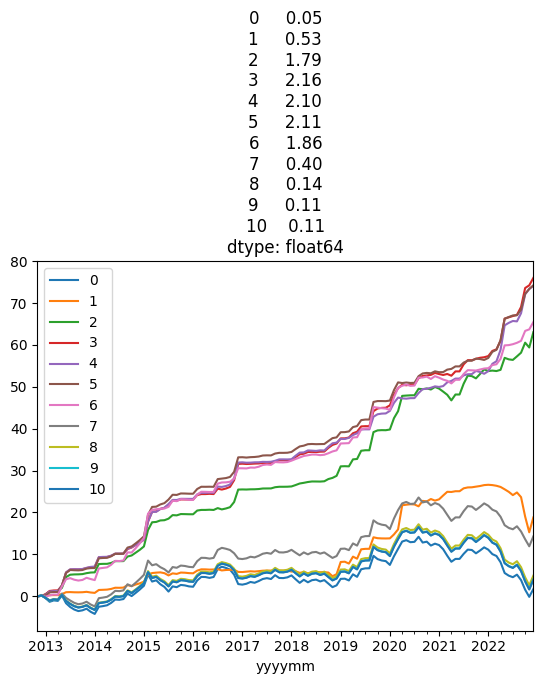

In [11]:
timed_returns = test_targets.reshape(-1, 1) * oos_predictions
together = pd.DataFrame(np.concatenate([test_targets.reshape(-1, 1), timed_returns], axis=1), index=test_dates)
(together / together.std()).cumsum().plot()
plt.title(f'{GoyalWelchData.sharpe_ratio(together)}')